In [1]:
# ONLY RUN THIS ONCE TO SET WORKING DIR - otherwise restart notebook and run whole code again to set path correctly.
import os
# Set working dir to \\Bluecrest
notebook_path = os.getcwd()
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import os
import quantstats as qs
import project_1_v3.data_manager as dm
import pandas as pd
import numpy as np
import project_1_v3.get_graph_pairs as ggp
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt import hp
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm
import importlib
import random
random.seed(1)
np.random.seed(1)

# Do not create _pycache_
import sys
sys.dont_write_bytecode = True

# Set paths to our alpha functions
sys.path.append('{notebook_path}\\project_1_v3\\functions_selected')

Features are generated/tested from 2018-01-01 - 2023-09-01.  

The test period is untouched/unseen to avoid forward looking bias

<b>The alphas below have been generated from our personal IP framework designed for my crypto trading system. Due to missing intraday data, I cannot run the full framework, so the signals found here may not be as resilient as the ones I would use in practice.  The code for the IP is not given</b>


In [35]:
# Form our alpha signals
def form_features(data):
    functions = os.listdir('project_1_v3\\functions_selected')
    functions = [i.split('.')[0] for i in functions]

    data['ret'] = np.log(data.adj_close/data.adj_close.shift(1))
    data['ret_3d_mean'] = data.ret.rolling(3).mean()
    data['ret_7d_mean'] = data.ret.rolling(7).mean()
    data['ret_21d_mean'] = data.ret.rolling(21).mean()

    data['ret_3d_median'] = data.ret.rolling(3).median()
    data['ret_7d_median'] = data.ret.rolling(7).median()
    data['ret_21d_median'] = data.ret.rolling(21).median()
    
    data['ret_3d_cum'] = (data.ret+1).rolling(3).apply(np.prod)
    data['ret_7d_cum'] = (data.ret+1).rolling(7).apply(np.prod)
    data['ret_21d_cum'] = (data.ret+1).rolling(21).apply(np.prod)

    data['ret_rate_change'] = data.ret.pct_change()

    data['ret_3d_skew'] = data.ret.rolling(3).skew()
    data['ret_7d_skew'] = data.ret.rolling(7).skew()
    data['ret_21d_skew'] = data.ret.rolling(21).skew()

    data['ret_3d_min'] = data.ret.rolling(3).min()
    data['ret_7d_min'] = data.ret.rolling(7).min()
    data['ret_21d_min'] = data.ret.rolling(21).min()

    data['ret_3d_max'] = data.ret.rolling(3).max()
    data['ret_7d_max'] = data.ret.rolling(7).max()
    data['ret_21d_max'] = data.ret.rolling(21).max()

    data['ret_3d_std'] = data.ret.rolling(3).std()
    data['ret_7d_std'] = data.ret.rolling(7).std()
    data['ret_21d_std'] = data.ret.rolling(21).std()
    
    for function in functions:
        func = importlib.import_module(f'project_1_v3.functions_selected.{function}')
        func = getattr(func, function)
        data[function] = func(data.ret, 
                            data.ret_3d_mean, data.ret_7d_mean, data.ret_21d_mean,  
                            data.ret_3d_median, data.ret_7d_median, data.ret_21d_median, 
                            data.ret_3d_cum, data.ret_7d_cum, data.ret_21d_cum, 
                            data.ret_rate_change, 
                            data.ret_3d_skew, data.ret_7d_skew, data.ret_21d_skew,  
                            data.ret_3d_min, data.ret_7d_min, data.ret_21d_min, 
                            data.ret_3d_max, data.ret_7d_max, data.ret_21d_max, 
                            data.ret_3d_std, data.ret_7d_std, data.ret_21d_std)
    
    # The target is 1 day forward return (this will be ranked later on)
    data['target'] = data.ret.shift(-1)
    data.dropna(inplace=True)
    return data

def form_dataset(index, symbol, start_date, end_date):
    data = dm.get_sym_dates_index(index, symbol, start_date, end_date)
    data = form_features(data)
    return data

# Hyperparameter tuning for the lightgbm model - taking a bayesian approach (treeparzen algo) for speed enhancement.
# The parameter range is chosen selective - based on experience.
class HPOpt:
    def __init__(self, train, val, featureCols):
        self.train = train
        self.val = val
        self.featureCols = featureCols
        lgb_clf_params = {
        'learning_rate':    0.01, 
        'max_depth':        hp.choice('max_depth', np.arange(2, 3, 1)),
        'max_bin':          hp.choice('max_bin', np.arange(2, 255, 1)),
        'num_leaves':       hp.choice('num_leaves',       [i for i in range(20,100,2)]),
        'n_estimators':     10000, 
        'min_gain_to_split': hp.uniform('min_gain_to_split',0, 100),
        'lambda_l1': hp.uniform('lambda_l1',0, 0.5),
        'lambda_l2': hp.uniform('lambda_l2',0, 0.5),
        'random_state':     1,
        'num_threads':      8,
        'min_data_in_bin': hp.choice('min_data_in_bin', np.arange(10, 2000, 5)),
        'min_data_in_leaf':  hp.choice('min_data_in_leaf', np.arange(10, 2000, 5)),
        'metric': 'rmse',
        'verbose':-1
                        }
        self.lgb_para = dict()
        self.lgb_para['clf_params'] = lgb_clf_params
    
    def getBestModelfromTrials(self, trials):
        valid_trial_list = [trial for trial in trials
                                if STATUS_OK == trial['result']['status']]
        losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
        index_having_minumum_loss = np.argmin(losses)
        best_trial_obj = valid_trial_list[index_having_minumum_loss]
        return best_trial_obj['result']['model']
    
    def train_func(self, para):
        tmp = []
        models = []

        train_set = lgb.Dataset(self.train[self.featureCols], label=self.train['target_rank'])
        val_set = lgb.Dataset(self.val[self.featureCols], label=self.val['target_rank'])
        clf = lgb.train(para, train_set, valid_sets=[val_set], callbacks=[lgb.early_stopping(stopping_rounds=50)])

        models.append({'model':clf})
        pred = clf.predict(self.val[self.featureCols])
        loss = np.sqrt(mse(self.val['target_rank'], pred))
        tmp.append(loss)
        tmp = np.mean(tmp)
        return {'loss': tmp, 'status': STATUS_OK, 'model':clf}
    
    def process(self, fn_name, space, trials, algo, max_evals):
        try:
            #fn = getattr(self, fn_name)
            # set random seed
  
            result = fmin(fn=self.lgb_clf, space=self.lgb_para['clf_params'], algo=algo, max_evals=max_evals, trials=trials, early_stop_fn=no_progress_loss(200), rstate=np.random.default_rng(1))
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def lgb_clf(self, para):
        return self.train_func(para)


User input below.
Please note the features/alphas are only extracted from the Nasdaq 100 stocks for a given period.
Changing the period/index will result in unknown result.

In [4]:
index = 'Nasdaq 100'
start_date = '2018-01-01'
end_date = '2024-09-01'

We use network approach to find the largest 'community' (Louvain algorithm).

This is done to identify stocks which have similar characteristics.

The metric used to group stocks together is the euclidean distance on their return profile.

In practice it would be wise to use the factor exposures of each stock to group them together - which will be a multidimensional approach.

In [5]:
# Find largest community
ggp.main(index, start_date, end_date)

0.9861983389137147
Largest community size: 36


100%|██████████| 630/630 [05:22<00:00,  1.95it/s]


In [6]:
# Load all of the common group stocks
symbols = pd.read_csv('full_community.txt', header=None)
symbols.columns = ['symbol']
symbols = symbols.symbol.values

In [7]:
# Construct our main dataset
df = []
for i in tqdm(symbols):
    df.append(form_dataset(index, i, start_date, end_date))
df = pd.concat(df)

# Get all of the columns of our features/alphas
feature_columns = [i for i in df.columns if 'generated' in i]

100%|██████████| 36/36 [00:11<00:00,  3.22it/s]


Below, prepare dataset for ML training.

The features are zscored (cross-sectionally). Clipped at -2,2 to remove outliers.

The forward returns (target) is zscored cross-sectionally. Clipped at -2,2 to remove outliers.

The aim is to predict the stocks which will over/under perform relative to each other.

In [10]:
def spearman_corr(x, y):
    n = len(x)
    rank_x = np.argsort(np.argsort(x))
    rank_y = np.argsort(np.argsort(y))
    covariance = np.sum((rank_x - np.mean(rank_x)) * (rank_y - np.mean(rank_y)))
    correlation = covariance / (np.std(rank_x) * np.std(rank_y) * (n - 1))
    return correlation

def corr_func(sub_df):
        return spearman_corr(sub_df['target'].values, sub_df['signal'].values)

def zscore_features(tmp):
    tmp[feature_columns] = tmp[feature_columns].rank()
    tmp[feature_columns] = (tmp[feature_columns] - tmp[feature_columns].mean())/tmp[feature_columns].std()
    return tmp

# normalize features cross-sectionally
df = df.groupby('date').apply(zscore_features).reset_index(drop=True)

def rank_targets(tmp):
    tmp['target_rank'] = tmp.target.rank()
    tmp['target_rank'] = (tmp.target_rank - tmp.target_rank.mean())/tmp.target_rank.std()
    return tmp

df = df.groupby('date').apply(rank_targets).reset_index(drop=True)

In [12]:
test_end = df.date.max()
test_start = test_end - pd.DateOffset(months=12)

val_end = test_start - pd.DateOffset(days=1)
val_start = val_end - pd.DateOffset(days=252*2)

# We drop 21 days (longest window used in feature creation) between train_end and val_start
train_end = val_start - pd.DateOffset(days=21)
train_start = df.date.min()

In [13]:
val = df[(df.date >= val_start) & (df.date <= val_end)]
train = df[(df.date >= train_start) & (df.date <= train_end)]
test = df[(df.date >= test_start) & (df.date <= test_end)]

#clip train target_rank
train['target_rank'] = np.clip(train.target_rank, -2, 2)

# clip features
for col in feature_columns:
    train[col] = np.clip(train[col], -2, 2)

In [14]:
train.shape, val.shape

((37473, 77), (12490, 77))

In [15]:
# Checking basic correlation of our signals vs target_rank.
train[['target_rank'] + feature_columns].corr(method='spearman')['target_rank']

target_rank                 1.000000
generated_function_10066   -0.018780
generated_function_10068   -0.017463
generated_function_11791   -0.011306
generated_function_11876   -0.010601
generated_function_11880    0.010438
generated_function_12548   -0.015562
generated_function_12593   -0.023980
generated_function_12641   -0.024934
generated_function_12676   -0.017915
generated_function_12722   -0.019703
generated_function_13701    0.020697
generated_function_14324   -0.010686
generated_function_14328    0.010319
generated_function_15046    0.018541
generated_function_1612     0.007545
generated_function_16500   -0.010556
generated_function_16504    0.010529
generated_function_17137   -0.017826
generated_function_18420   -0.010449
generated_function_18424    0.010543
generated_function_19092   -0.015596
generated_function_19137   -0.024813
generated_function_19266   -0.019783
generated_function_2740    -0.010862
generated_function_2744     0.010112
generated_function_2760     0.009481
g

<b>IMPORTANT</b>

This is something which I have found success with in practice - cannot be found in textbooks.

We resample our train data, in this case 2 times, alternating samples.  This achieves a couple of advantages:
1. Helps break serial correlation due to the nature of rolling windows.  This enables the ML model to learn more of the global structure of the data rather than local.
2. Creates multiple train datasets - allows multiple models to be trained and ensembled which resullts in more stable predictions.

In [16]:
nth_dates = list(train.date.unique())
train_1_dates = nth_dates[0::2]
train_2_dates = nth_dates[1::2]

train_1 = train[train.date.isin(train_1_dates)]
train_2 = train[train.date.isin(train_2_dates)]

In [37]:
# Get benchmark metric (e.g. a naive 0 prediction).  This is to see whether our models are learning anything or not.
np.sqrt(mse(val.target_rank, [0]*val.shape[0]))

0.9860110416315709

Below we train and tune our models.

There are several things that go into making an accurate model. Can discuss on call if needed.

In [18]:
obj = HPOpt(train=train_1, val=val, featureCols=feature_columns)
trials = Trials()
obj.process(fn_name='lgb_clf', space=obj.lgb_para, trials=trials, algo=tpe.suggest, max_evals=50000)
best_model_1 = trials.best_trial['result']['model']

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:                       
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve f

Train second model

In [19]:
obj = HPOpt(train=train_2, val=val, featureCols=feature_columns)
trials = Trials()
obj.process(fn_name='lgb_clf', space=obj.lgb_para, trials=trials, algo=tpe.suggest, max_evals=50000)
best_model_2 = trials.best_trial['result']['model']

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:                       
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve for 50 rounds                         
Early stopping, best iteration is:                                                   
[1]	valid_0's rmse: 0.986011
Training until validation scores don't improve f

Form predictiosn from both models on our test dataset.

Our final prediction is the mean of both predictions

In [20]:
test['pred_1'] = best_model_1.predict(test[feature_columns])
test['pred_2'] = best_model_2.predict(test[feature_columns])
test['pred'] = 0.5*(test.pred_1 + test.pred_2)

In [21]:
test[['target_rank','target','pred_1','pred_2','pred']].corr(method='spearman')

,target_rank,target,pred_1,pred_2,pred
target_rank,1.000000,0.801685,0.021883,0.011504,0.021751
target,0.801685,1.000000,0.014449,0.003551,0.014057
pred_1,0.021883,0.014449,1.000000,0.503281,0.973162
pred_2,0.011504,0.003551,0.503281,1.000000,0.672845
pred,0.021751,0.014057,0.973162,0.672845,1.000000


Even though very slightly, below we can see our models are beating a naive 0 predictions, so they are learning some structure of our train data.

This is interesting to see since I have barely optimized my alpha generation approach from crypto.

Also this is indiciates that my framework has ability to generate alpha within the equities market

In [22]:
mse(test.target_rank, test.pred), mse(test.target_rank, [0]*test.shape[0])

(0.9718503866270136, 0.9722191720654442)

We form a very basic portfolio.

Go long top half and short bottom half.

No risk management is carried out.

In practice, we would be running factor neutral, or at the minimum beta neutral.

In [23]:
def port_form(tmp):
    tmp.sort_values('pred', inplace=True)
    num = tmp.shape[0]//2
    long = tmp.tail(num)
    long['side'] = 'Buy'
    short = tmp.head(num)
    short['side'] = 'Sell'
    tmp = pd.concat([long, short])
    return tmp

In [24]:
port = test.groupby('date').apply(port_form).reset_index(drop=True)
port[['target_rank','target','pred_1','pred_2','pred']].corr(method='spearman')

Again shows models out performing a naive 0 prediction

In [26]:
mse(port.target_rank, port.pred), mse(port.target_rank, [0]*port.shape[0])

(0.9719187239905209, 0.9722882871576041)

In [27]:
def pnl(tmp):
    tmp['pnl'] = np.where(tmp.side=='Buy', tmp.target, -tmp.target)
    return tmp.pnl.mean()

In [28]:
pnl = port.groupby('date').apply(pnl).reset_index()
pnl.columns = ['date','pnl']
pnl.set_index('date', inplace=True)

Shows very promising result below.  A sharpe of 2.8 (no costs take into consideration).

Considering this is a toy example where the pipelines have not be optimized for equties at all, nor any risk management taken into consideration, it is very interesting to see my personal IP framework showing positive results.  In crypto, this same framework is generating 5 sharpe live (after costs).

                    Strategy
------------------  ----------
Start Period        2023-08-29
End Period          2024-08-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   10.63%
CAGR﹪              7.2%

Sharpe              2.8
Prob. Sharpe Ratio  99.68%
Sortino             4.41
Sortino/√2          3.12
Omega               1.59

Max Drawdown        -1.57%
Longest DD Days     49

Gain/Pain Ratio     0.59
Gain/Pain (1M)      58.42

Payoff Ratio        1.15
Profit Factor       1.59
Common Sense Ratio  2.22
CPC Index           1.06
Tail Ratio          1.4
Outlier Win Ratio   2.98
Outlier Loss Ratio  3.8

MTD                 0.34%
3M                  1.42%
6M                  3.0%
YTD                 5.37%
1Y                  10.63%
3Y (ann.)           7.2%
5Y (ann.)           7.2%
10Y (ann.)          7.2%
All-time (ann.)     7.2%

Avg. Drawdown       -0.43%
Avg. Drawdown Days  10
Recovery Factor     6.49
Ulcer Index         0.0
Serenity Index      5.02


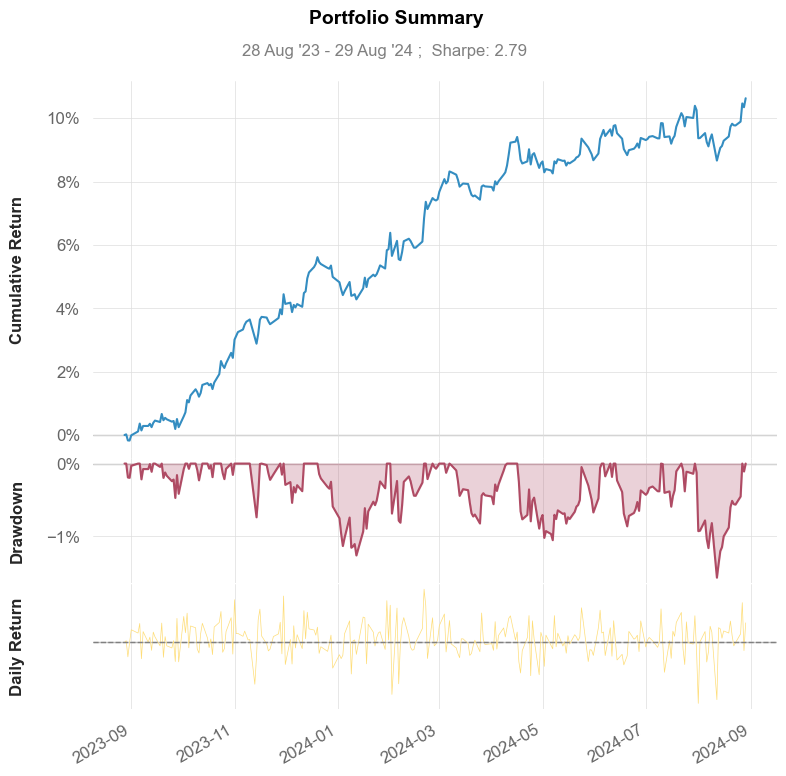

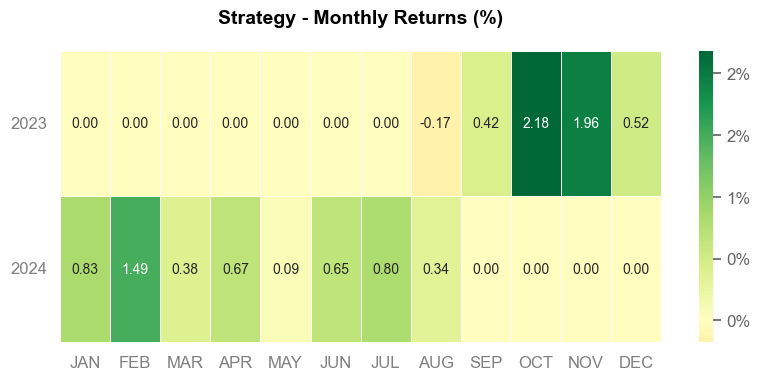

In [33]:
qs.reports.basic(pnl.pnl, periods_per_year=252)